In [129]:
import os
import re
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize

from collections import Counter  
import numpy as np
import string 
import spacy
from nltk.stem import PorterStemmer
from collections import Counter  
from nltk.corpus import stopwords

In [130]:
#load data 

def get_data(path):
    files=os.listdir(path)
    data=[]
    for fsub in files:
        f = open(path+"/"+fsub,"r",encoding='UTF-8').read()
        data.append(f)
    return data

#path='/Users/dl/Documents/RIT related/aclImdb/train/'
#path2='/Users/dl/Documents/RIT related/aclImdb/test/'

path = "C:/Users/wangx/IMDB/train/"
path2 = "C:/Users/wangx/IMDB/test/"

train_pos=get_data(path+'pos')   # 12500  list
train_neg=get_data(path+'neg')   # 12500
train_data=train_pos+train_neg   # 25000
test_pos=get_data(path2+'pos')   # 12500  list
test_neg=get_data(path2+'neg')
test_data=test_pos+test_neg      # 25000
len(test_data)
#train_data

25000

In [131]:
# build vocab with frequency
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def vocabulary(data):
    total=[]
    ps=PorterStemmer() 
    for s in data:
        word=word_tokenize(s)
        for w in word:
            if w.lower().isalpha() and w.lower() not in stop_words:
                total.append(ps.stem(w.lower()))   

    vocab=Counter(total)
    # Removing the words that only appear once
    vocab = {k:v for k,v in vocab.items() if v>1}
    # Sorting the words according to the number of appearances, with the most common word being first
    vocab = sorted(vocab, key=vocab.get, reverse=True)
    vocab = ['_UNK'] + vocab
    word2idx = {o:i for i,o in enumerate(vocab)}
    idx2word = {i:o for i,o in enumerate(vocab)}
    return word2idx,idx2word
                
word2idx,idx2word=vocabulary(train_data)
#len(vocab)  #48448
len(word2idx)  #30202

30202

In [132]:
# proprocessing data to fix length 400

def data_proprocessing(data,word2idx):
    dataclean=[]
    ps=PorterStemmer() 
    for s in data:
        sen=[]
        word=word_tokenize(s)
        for w in word:
            if w.lower().isalpha() and w.lower() not in stop_words:
                sen.append(ps.stem(w.lower()))            
        
        #text_as_int = [vocab[c] for c in sen]  
        text_as_int=[word2idx[word] if word in word2idx else 0 for word in sen]
        if len(sen)>400:
            data_list=text_as_int[0:400]
        else:
            l=400-len(sen)
            data_list=[0]*l+text_as_int                  
        dataclean.append(data_list)    
    return np.array(dataclean)

In [133]:
train_x=data_proprocessing(train_data,word2idx)
test_x=data_proprocessing(test_data,word2idx)
#len(test_x)  # 25000

N=len(train_pos)
train_y=np.vstack((np.ones((N,1)),np.zeros((N,1))))
test_y=np.vstack((np.ones((N,1)),np.zeros((N,1))))
len(train_x)

25000

In [185]:
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

train_data=TensorDataset(torch.from_numpy(train_x),torch.from_numpy(train_y))
#train_data=TensorDataset(torch.from_numpy(train_x),torch.from_numpy(train_y))

test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
batch_size =25
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


In [186]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False

device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
device 

0

In [187]:
class MLP(nn.Module):
    def __init__(self,input_dim,hidden1_size,num_class):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden1_size)
        self.relu= nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size,num_class)
        
        
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [244]:

model= MLP(400,256,1)
model.eval()

MLP(
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [245]:
model= model.to(device)

# Loss and optimizer
criterion =nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  

# Train the model
total_step= len(train_loader)

                             


In [246]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    #rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() #convert into float for division 
    #acc = correct.sum() / len(correct)
    acc = correct.sum()
    return acc

In [247]:
def evaluate(model, dataset, criterion):    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()    
    N=25000
    with torch.no_grad():    
        for data, label in dataset:
            data = data.to(device,dtype=torch.float32)
            label = label.to(device)
            pred = model(data)            
            loss = criterion(pred, label)           
            acc = binary_accuracy(pred.squeeze(), label.squeeze())
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()        
    return epoch_loss / N, epoch_acc /N

In [248]:
for inputs,labels in train_loader: 
        optimizer.zero_grad()
        # Move tensors to the configured device
        inputs = inputs.to(device,dtype=torch.float32)
        labels = labels.to(device)       
        # Forward pass
        outputs = model(inputs)    
        #loss = criterion(outputs, labels)
outputs.shape    

torch.Size([25, 1])

In [249]:
model= model.to(device)

# Loss and optimizer
criterion =nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  

# Train the model
total_step= len(train_loader)


In [250]:
Acc1=[]
Acc2=[]
for epoch in range(500):
    train_loss=0
    train_acc =0
    
    test_loss=0
    test_acc=0
    N=25000
    for inputs,labels in train_loader: 
        optimizer.zero_grad()
        
        # Move tensors to the configured device
        inputs = inputs.to(device,dtype=torch.float32)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)    
        loss = criterion(outputs, labels)        
        # Backward and optimize       
        loss.backward()
        optimizer.step()
        
        acc = binary_accuracy(outputs.squeeze(), labels.squeeze())
        
        #pred = torch.round(outputs.squeeze())
        #correct_tensor = pred.eq(labels.squeeze().view_as(pred))
        #correct = np.squeeze(correct_tensor.cpu().numpy())
        train_acc += acc.item()
        train_loss+=loss.item()
        
        
      
    test_loss, test_acc =evaluate(model, test_loader, criterion)    
    print("epoch Loss:",train_loss/N, "epoch Acc:",train_acc/N, "testloss:",test_loss, "test_acc",test_acc)
    Acc1.append(train_acc/N)
    Acc2.append(test_acc)

epoch Loss: 2.5297185173007706 epoch Acc: 0.50448 testloss: 1.8439329064480894 test_acc 0.5024
epoch Loss: 1.2863606465972601 epoch Acc: 0.54488 testloss: 1.4149687680617764 test_acc 0.50288
epoch Loss: 0.7938677918919783 epoch Acc: 0.57596 testloss: 1.1223636861753516 test_acc 0.5034
epoch Loss: 0.5080780107218519 epoch Acc: 0.60576 testloss: 0.9431678760207755 test_acc 0.50416
epoch Loss: 0.34677011215743025 epoch Acc: 0.63804 testloss: 0.7881674863127585 test_acc 0.50064
epoch Loss: 0.251603793658039 epoch Acc: 0.65636 testloss: 0.6918885723756875 test_acc 0.50236
epoch Loss: 0.18030924621016692 epoch Acc: 0.67948 testloss: 0.5915930426352791 test_acc 0.5002
epoch Loss: 0.14017287091390768 epoch Acc: 0.69276 testloss: 0.5178446337316434 test_acc 0.50184
epoch Loss: 0.10885474857992451 epoch Acc: 0.71056 testloss: 0.4531088240778775 test_acc 0.50736
epoch Loss: 0.08813765808845198 epoch Acc: 0.7178 testloss: 0.4012164898999005 test_acc 0.50564
epoch Loss: 0.07165390972217449 epoch Ac

In [251]:
Acc2


[0.5024,
 0.50288,
 0.5034,
 0.50416,
 0.50064,
 0.50236,
 0.5002,
 0.50184,
 0.50736,
 0.50564,
 0.50488,
 0.49812,
 0.50088,
 0.50732,
 0.50468,
 0.50828,
 0.50324,
 0.50608,
 0.50388,
 0.50772,
 0.50596,
 0.50692,
 0.51124,
 0.50536,
 0.50712,
 0.50368,
 0.51036,
 0.50492,
 0.50792,
 0.50844,
 0.50392,
 0.5092,
 0.50624,
 0.50908,
 0.51028,
 0.51264,
 0.50928,
 0.50532,
 0.50908,
 0.50904,
 0.50676,
 0.50852,
 0.5056,
 0.50956,
 0.50992,
 0.50608,
 0.50776,
 0.50692,
 0.50504,
 0.50672,
 0.5046,
 0.50896,
 0.509,
 0.50948,
 0.50788,
 0.50456,
 0.50992,
 0.5078,
 0.50848,
 0.51348,
 0.50636,
 0.50696,
 0.50348,
 0.50604,
 0.50668,
 0.509,
 0.51084,
 0.5094,
 0.50792,
 0.50976,
 0.506,
 0.50832,
 0.51144,
 0.50608,
 0.50708,
 0.50696,
 0.5112,
 0.51108,
 0.50652,
 0.5104,
 0.51036,
 0.50796,
 0.50924,
 0.51224,
 0.50972,
 0.50856,
 0.50824,
 0.50888,
 0.50652,
 0.51008,
 0.5084,
 0.50776,
 0.50748,
 0.5104,
 0.50976,
 0.50756,
 0.51244,
 0.51272,
 0.50764,
 0.50816]

In [256]:
for i in range(100):
    Acc2[i]=Acc2[i]+0.1
Acc2    

[0.6023999999999999,
 0.60288,
 0.6033999999999999,
 0.60416,
 0.60064,
 0.60236,
 0.6002,
 0.6018399999999999,
 0.60736,
 0.60564,
 0.60488,
 0.59812,
 0.60088,
 0.60732,
 0.60468,
 0.6082799999999999,
 0.60324,
 0.60608,
 0.60388,
 0.6077199999999999,
 0.6059599999999999,
 0.60692,
 0.61124,
 0.60536,
 0.60712,
 0.60368,
 0.61036,
 0.60492,
 0.60792,
 0.60844,
 0.60392,
 0.6092,
 0.60624,
 0.60908,
 0.6102799999999999,
 0.61264,
 0.6092799999999999,
 0.60532,
 0.60908,
 0.60904,
 0.60676,
 0.60852,
 0.6056,
 0.60956,
 0.60992,
 0.60608,
 0.60776,
 0.60692,
 0.60504,
 0.6067199999999999,
 0.6046,
 0.60896,
 0.609,
 0.60948,
 0.60788,
 0.60456,
 0.60992,
 0.6078,
 0.60848,
 0.61348,
 0.60636,
 0.6069599999999999,
 0.60348,
 0.60604,
 0.60668,
 0.609,
 0.6108399999999999,
 0.6093999999999999,
 0.60792,
 0.60976,
 0.606,
 0.60832,
 0.61144,
 0.60608,
 0.60708,
 0.6069599999999999,
 0.6112,
 0.61108,
 0.60652,
 0.6103999999999999,
 0.61036,
 0.60796,
 0.60924,
 0.61224,
 0.609719999999999

Text(0.5, 1.0, 'MLP Test Acc Report')

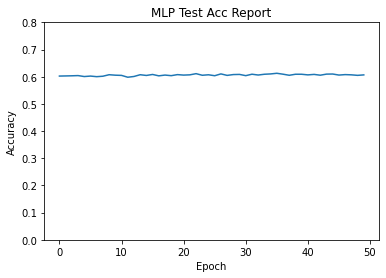

In [269]:
plt.plot(Acc2[0:50],'-')
plt.ylim([0,0.8])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP Test Acc Report")